# Greenland Ice Velocity time-series dataset tutorial
The PROMICE Ice Velocity product is a time-series of Greenland Ice Sheet velocity mosaics based on ESA Sentinel-1 SAR offset tracking (spatial resolution: 200 m). A new mosaic spanning 2 Sentinel-1A/-1B/-1C cycles is posted every 12 days, with each new mosaic supplied as a NetCDF file. The data product is described in detail in [Solgaard et al. (2021)](https://doi.org/10.5194/essd-13-3491-2021)
We aim to make each new mosaic available within 10 days of the last included acquisition.

Here, we will look at how to load multiple files in the dataset and handle them as a time-series, using example points and flowlines. Specifically, we will:
1. Download a series of dataset files from the Dataverse portal
2. Visualize and animate velocities over a given region
3. Produce a time-series of velocities at a given point
4. Produce a time-series of average velocities across a flowline

For more information on how to handle a single file in the dataset, please refer to the previous introductory tutorial.

So first, let's import all the packages we will be using.

In [2]:
# For data downloading and file handling
import os
import re
import requests
import glob

# For time querying
from datetime import datetime

# For plotting
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# For web scraping
from bs4 import BeautifulSoup

# For dataset loading and handling
import xarray as xr
import numpy as np
from scipy.spatial import cKDTree
from scipy.interpolate import griddata

## 1. Download the dataset from the Dataverse portal
The PROMICE Ice Velocity product is available on the [GEUS Dataverse](https://doi.org/10.22008/FK2/LFZLZN). To download the entire dataset, we can use wget through the command line:

```
$ wget -r -e robots=off -nH --cut-dirs=3 --content-disposition "https://dataverse.geus.dk/api/datasets/:persistentId/dirindex?persistentId=doi:10.22008/FK2/LFZLZN"
```

Or we can download individual files using wget in a Python console. In this example, we will download all files from May to October 2025.

In [2]:
BASE_API = "https://dataverse.geus.dk"
PID = "doi:10.22008/FK2/LFZLZN"

# Define date range for downloading files
TARGET_START = datetime(2025, 5, 1)
TARGET_END = datetime(2025, 10, 1)

# Start session
SESSION = requests.Session()


def extract_date_range(filename):
    """
    Extracts two YYYYMMDD dates from filename
    Example:
      IV_ROTR_20251019_20251112.nc
    """
    # Find date strings
    dates = re.findall(r"(20\d{6})", filename)
    if len(dates) < 2:
        return None, None

    # Convert strings and return as datetime objects
    d1 = datetime.strptime(dates[0], "%Y%m%d")
    d2 = datetime.strptime(dates[1], "%Y%m%d")
    return d1, d2


def ranges_overlap(a_start, a_end, b_start, b_end):
    """Checks if two date ranges overlap"""
    return max(a_start, b_start) <= min(a_end, b_end)


def download_file(file_id, filename, out_dir):
    # Filter to only download .nc files
    if not filename.lower().endswith(".nc"):
        return

    # Filter to only downland files between the two dates defined
    f_start, f_end = extract_date_range(filename)
    if not f_start or not ranges_overlap(f_start, f_end, TARGET_START, TARGET_END):
        return

    # Download file
    print(f"Downloading {filename}...")
    os.makedirs(out_dir, exist_ok=True)
    path = os.path.join(out_dir, filename)
    url = f"{BASE_API}/api/access/datafile/{file_id}"
    r = SESSION.get(url, stream=True)
    r.raise_for_status()
    with open(path, "wb") as f:
        for chunk in r.iter_content(8192):
            f.write(chunk)


def walk_dir(url=f"{BASE_API}/api/datasets/:persistentId/dirindex?persistentId={PID}", out_dir="."):
    # Start session with url
    r = SESSION.get(url)
    r.raise_for_status()

    # Parse URL contents
    soup = BeautifulSoup(r.text, "html.parser")

    # Iterate all <a> links in the table
    for link in soup.find_all("a"):
        href = link.get("href", "")
        filename = link.text.strip()

        # Download access/datafile URLs only
        if "/api/access/datafile/" in href:
            file_id = href.split("/")[-1]
            download_file(file_id, filename, out_dir)


# Execute downloading routine
walk_dir()

We can check that the files have been downloaded like so.

In [4]:
# Generate list of NetCDF files from download directory
search_directory="*.nc"
file_list = sorted(glob.glob(search_directory))

# Print list
print(file_list)

['IV_ROTR_20250410_20250504.nc', 'IV_ROTR_20250422_20250516.nc', 'IV_ROTR_20250504_20250528.nc', 'IV_ROTR_20250516_20250609.nc', 'IV_ROTR_20250528_20250621.nc', 'IV_ROTR_20250609_20250703.nc', 'IV_ROTR_20250621_20250715.nc', 'IV_ROTR_20250703_20250727.nc', 'IV_ROTR_20250715_20250808.nc', 'IV_ROTR_20250727_20250820.nc', 'IV_ROTR_20250808_20250901.nc', 'IV_ROTR_20250820_20250913.nc', 'IV_ROTR_20250901_20250925.nc', 'IV_ROTR_20250913_20251007.nc', 'IV_ROTR_20250925_20251019.nc']


## 2. Visualize and animate velocities over a given region
Now we have our files downloaded, let's open one and visualize one of the files in the dataset over a defined region. To open a file, we will use xarray which is a Python package for handling multi-dimensional arrays.

In [5]:
# Define file name to open
infile = file_list[0]

# Open file as xarray dataset
ds = xr.open_dataset(infile)

# Print dataset metadata and overview of contents
print(ds)

<xarray.Dataset> Size: 3GB
Dimensions:                                  (time: 1, bnds: 2, y: 13500,
                                              x: 7500)
Coordinates:
  * time                                     (time) datetime64[ns] 8B 2025-04-22
  * y                                        (y) float64 108kB -6.5e+05 ... -...
  * x                                        (x) float64 60kB -6.5e+05 ... 8....
Dimensions without coordinates: bnds
Data variables:
    crs                                      |S1 1B ...
    time_bnds                                (time, bnds) datetime64[ns] 16B ...
    land_ice_surface_easting_velocity        (time, y, x) float32 405MB ...
    land_ice_surface_northing_velocity       (time, y, x) float32 405MB ...
    land_ice_surface_vertical_velocity       (time, y, x) float32 405MB ...
    land_ice_surface_velocity_magnitude      (time, y, x) float32 405MB ...
    land_ice_surface_easting_velocity_std    (time, y, x) float32 405MB ...
    land_ice_surfa

We can use xarray's plotting routines to visulize the dataset as a velocity field. Let's visualize the dataset over the region surrounding Narsap Sermia, a tidewater outlet glacier that terminates into Nuup Kangerlua (also known as Nuuk Fjord) in southwest Greenland.

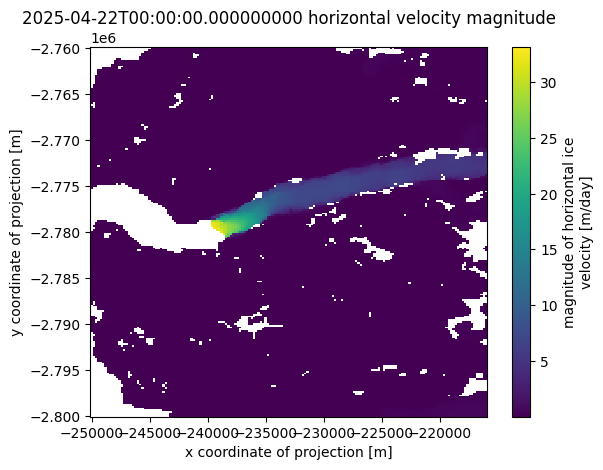

In [6]:
# Extract subset around Narsap Sermia
subset = ds.sel(
    x=slice(-250000, -216000),     # lat metres (EPSG:3413)
    y=slice(-2760000, -2800000)    # lon metres (EPSG:3413)
)

# Select horizontal velocity magnitude variable
vel = subset["land_ice_surface_velocity_magnitude"]

# Plot data
plt.figure()
vel.isel(time=0).plot()
plt.title(f"{vel.time.values[0]} horizontal velocity magnitude")
plt.show()

If we load each file individually and colate all velocity magnitude data together from this region, then we can create animations that visualize the change in velocities over the course of summer 2025.

In [10]:
# Open all NetCDF files and combine along coordinates
# Warning: this functionality requires dask for parallel dataset handling
ds_all = xr.open_mfdataset(
    file_list,
    data_vars="all",
    combine="by_coords",
    parallel=True
)

# Subset all datasets to Narsap Sermia
subset_all = ds_all.sel(
    x=slice(-250000, -216000),
    y=slice(-2760000, -2800000)
)
vel_all = subset_all["land_ice_surface_velocity_magnitude"]

# Prime plotting area
fig, ax = plt.subplots(figsize=(6, 6))

# Plot first timestep
im = vel_all.isel(time=0).plot(
    ax=ax,
    add_colorbar=True,
    cmap="viridis"
)
title = ax.set_title(str(vel_all.time.values[0]))

# Define function for updating plotting area with next dataset subset
def update(frame):
    im.set_array(vel_all.isel(time=frame).values.ravel())
    title.set_text(str(vel_all.time.values[frame]))
    return im,

# Define animation
anim = FuncAnimation(
    fig,
    update,
    frames=vel_all.sizes["time"],
    interval=300  # milliseconds between frames
)

# Plot animation
plt.close(fig)
HTML(anim.to_jshtml())


## 3. Produce a time-series of velocities at a given point
We can also iterate through files to produce a time-series of velocities, and thus examine how the velocity of the Greenland Ice Sheet evolves through time. For this example, we will:
- Choose a point in the Petermann Glacier catchment, North Greenland
- Read all velocity data from this point from May to October 2025
- Compile the velocity data into a time-series
- Visualize the time-series

Let's first define our point of interest and then overlay it on top of one of the velocity datasets to check it is located correctly.

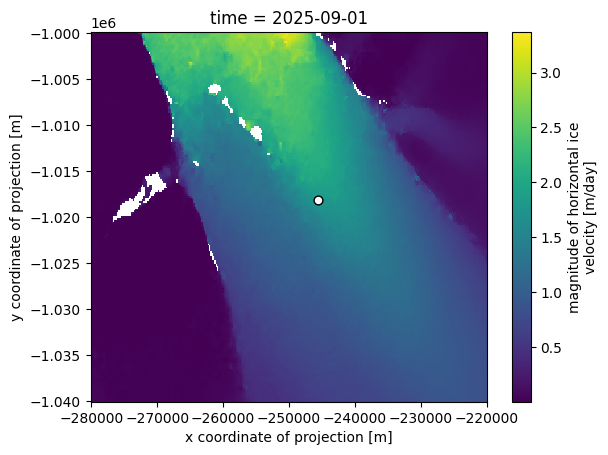

In [14]:
# Define point of interest (coordinates in metres, EPSG:3413)
x = -245600
y = -1018200

# Open an example dataset file for plotting
ds = xr.open_dataset("IV_ROTR_20250820_20250913.nc")

# Plot horizontal velocity magnitude at Petermann Glacier
subset = ds.sel(
    x=slice(-280000, -220000),
    y=slice(-1000000, -1040000)
)
vel = subset["land_ice_surface_velocity_magnitude"]
plt.figure()
vel.isel(time=0).plot()

# Overlay point location
plt.scatter(x, y, c="white", s=40, marker="o", edgecolors="black")

# Show plot
plt.show()

Now we have our point of interest defined, we will cycle through each velocity file, extract the horizontal velocity magnitude, and compile them all with corresponding time steps.

In [21]:
# Prime variables to write information to
time = []
vel = []

# Iterate through files
for i in file_list:

    # Open dataset
    ds = xr.open_dataset(i)

    # Subset to defined point, picking the nearest grid point
    subset = ds.sel(
        x = x,
        y = y,
        method="nearest"
        )

    # Extract horizontal velocity magnitude and timestep
    vel.append(subset["land_ice_surface_velocity_magnitude"].values)
    time.append(subset["time"].values)

print(time)
print(vel)

[array(['2025-04-22T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-05-04T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-05-16T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-05-28T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-06-09T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-06-21T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-07-03T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-07-15T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-07-27T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-08-08T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-08-20T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-09-01T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-09-13T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-09-25T00:00:00.000000000'], dtype='datetime64[ns]'), array(['2025-10-07T00:00:00.000000000'], dtype='datetime64[ns]')]
[array([1

Now we can plot these as a time-series, visualizing change in velocity at our defined point from May to October 2025.

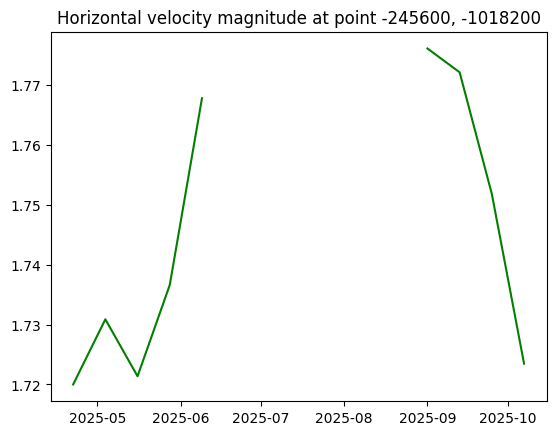

In [22]:
# Prime plotting space
plt.figure()

# Plot velocities over time with error bars
plt.plot(time, vel, color="green")
plt.title(f"Horizontal velocity magnitude at point {x}, {y}")

# Show plot
plt.show()

## 4. Produce a time-series of average velocities across a flowline
Now let's try to generate a time-series of velocities across a flowline.

This flowline should be a one-dimensional line that represents a glacier's primary path of ice flow. We will firstly make a hypothetical flowline ourselves over the catchment of Hagen Bræ in Northeast Greenland. Then we will generate a velocity time-series over this flowline, capturing the average, minimum and maximum velocity.

Firstly, let's define our flowline as a set of predefined points. Then we will generate evenly spaced points along our flowline, and compute the cumulative distance along this. We'll plot it onto the first velocity field in our dataset, to see how it looks.

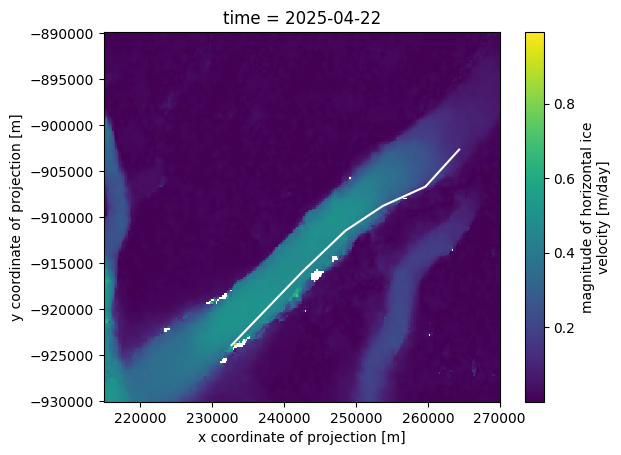

In [28]:
# Define flowline point locations
flowline_x = np.array([264352, 259672, 253754, 248511, 242556, 237624, 232692])
flowline_y = np.array([-902677, -906701, -908797, -911508, -915952, -919951, -923950])


dist_flowline = np.zeros(len(flowline_x))
for i in range(1, len(flowline_x)):
    dx = flowline_x[i] - flowline_x[i-1]
    dy = flowline_y[i] - flowline_y[i-1]
    dist_flowline[i] = dist_flowline[i-1] + np.sqrt(dx**2 + dy**2)

# Number of points along flowline
n_points = 100
even_dist = np.linspace(0, dist_flowline[-1], n_points)

# Interpolate x, y at evenly spaced distances
x_even = np.interp(even_dist, dist_flowline, flowline_x)
y_even = np.interp(even_dist, dist_flowline, flowline_y)

# Plot horizontal velocity magnitude at Hagen Bræ
ds = xr.open_dataset(file_list[0])
subset = ds.sel(
    x=slice(215000, 270000),
    y=slice(-890000, -930000)
)
vel = subset["land_ice_surface_velocity_magnitude"]
plt.figure()
vel.isel(time=0).plot()

# Overlay point location
plt.plot(x_even, y_even, c="white")

# Show plot
plt.show()

We can now extract velocity values at the nearest grid points of each dataset using a nearest neighbour search across flattened grid coordinates in our velocity dataset.

In [29]:
time = []
flowline_velocities = []

for f in file_list:
    ds = xr.open_dataset(f)
    ds_sub = ds.sel(
        x=slice(215000, 270000),
        y=slice(-890000, -930000)
    )

    # Flatten grid coordinates
    xx, yy = np.meshgrid(ds_sub.x.values, ds_sub.y.values)
    x_grid = xx.ravel()
    y_grid = yy.ravel()

    vel_data = ds_sub["land_ice_surface_velocity_magnitude"].isel(time=0).values.ravel()  # first time step
    valid_mask = ~np.isnan(vel_data)
    x_grid = x_grid[valid_mask]
    y_grid = y_grid[valid_mask]
    vel_data = vel_data[valid_mask]

    # Use cKDTree for nearest neighbor search
    tree = cKDTree(np.column_stack([x_grid, y_grid]))
    dist_nn, idx_nn = tree.query(np.column_stack([x_even, y_even]))
    vel_profile = vel_data[idx_nn]

    time.append(ds.time.values[0])
    flowline_velocities.append(vel_profile)

print(flowline_velocities)

[array([0.10443575, 0.11009385, 0.11434979, 0.13075845, 0.1407668 ,
       0.15199366, 0.164538  , 0.1756117 , 0.18336259, 0.19560799,
       0.19795366, 0.19905458, 0.19145323, 0.18632545, 0.1778061 ,
       0.14917397, 0.11993693, 0.13532875, 0.11514866, 0.08627935,
       0.13461079, 0.1659002 , 0.22844732, 0.25212443, 0.26373982,
       0.26020315, 0.2679644 , 0.28625137, 0.27420655, 0.26170614,
       0.2609946 , 0.30913448, 0.30752584, 0.32987636, 0.35128978,
       0.35634866, 0.39099988, 0.40305862, 0.41238403, 0.42842522,
       0.4443558 , 0.4499429 , 0.4620073 , 0.45371938, 0.4585519 ,
       0.43158326, 0.44234523, 0.47811905, 0.4734886 , 0.48546863,
       0.48806378, 0.47307485, 0.45458812, 0.45769745, 0.4562055 ,
       0.45762482, 0.46480975, 0.47107467, 0.4677587 , 0.46832153,
       0.46588987, 0.46220133, 0.45907375, 0.46489275, 0.47479564,
       0.47326764, 0.48088685, 0.47900742, 0.47698265, 0.4817773 ,
       0.48204312, 0.483597  , 0.4837628 , 0.48452795, 0.4833

And then we can plot our velocity profile along the flowline, specifically plotting distance along the flowline versus velocity.

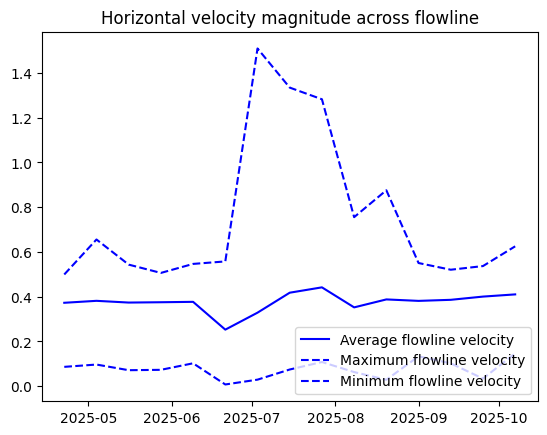

In [30]:
# Prime plotting space
plt.figure()

# Plot velocity time-series
flowline_average = [np.mean(i) for i in flowline_velocities]
plt.plot(time, flowline_average, color="blue", label="Average flowline velocity")

flowline_max = [np.max(i) for i in flowline_velocities]
plt.plot(time, flowline_max, color="blue", linestyle="--", label="Maximum flowline velocity")

flowline_min = [np.min(i) for i in flowline_velocities]
plt.plot(time, flowline_min, color="blue", linestyle="--", label="Minimum flowline velocity")

plt.legend(loc="lower right")
plt.title(f"Horizontal velocity magnitude across flowline")

# Show plot
plt.show()